# Tutorial

cryoswath: python package, offering tools to swath process CryoSat-2 data.

**Scope:**  

Focused on mountain glaciers, where POCA fails.
Mainly users should eventually be able to calculate gridded dh/dt.

In [1]:
# make the package available/from search path
import sys
sys.path.insert(0, "..")

## tl;dr

To obtain gridded aggregates of point elevation estimates, first make
sure the dependencies are available. If you haven't done so, install the
packages listed in [`../requirements.txt`](../requirements.txt), and
download
[ArcticDEM mosaic at 100 m](https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v4.1/100m/arcticdem_mosaic_100m_v4.1.tar.gz)
and extract the `*_dem.tif` to `../data/auxiliary/DEM/`. Then run the
following:

(The L1b data of ground tracks in the proximity of your region of
interest will be downloaded, processed, stored, aggregated, and finally
the product will be saved to disk).

In [2]:
import cryoswath
# cryoswath.l3.build_dataset(region_of_interest="09-02", # any RGI o2region
#                            start_datetime="2014-07", # like yyyy-mm-dd with optional month and day
#                            end_datetime="2023-10",
#                         #    agg_time=pandas.DateOffset(months=3), # months pandas offset. if required load pandas
#                         #    timestep=pandas.DateOffset(months=1),
#                         #    spatial_res_meter=500, # in meter
#                            )

/home/jan/Software/anaconda3/envs/cryoswath/lib/python3.10/abc.py:106: FutureWarning: xarray subclass l1b_data should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/home/jan/Software/anaconda3/envs/cryoswath/lib/python3.10/abc.py:106: FutureWarning: xarray subclass l3_data should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


## Step-by-step

The step-by-step guide is work in progress. Feel free to have a sneak-peak into the

If you haven't done so, install the
packages listed in [`../requirements.txt`](../requirements.txt), and
download
[ArcticDEM mosaic at 100 m](https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v4.1/100m/arcticdem_mosaic_100m_v4.1.tar.gz)
and extract the `*_dem.tif` to `../data/auxiliary/DEM/`. Further, you'll
probably need to download the RGI data (you'll be prompted) and you may
need to convert the esri files to feather (you can use the helper
function in module gis).

If you have custom demands, you may be interested to understand how you
can use the tools as you need them. Below, I will introduce some handy
once.

Lets get a list of CryoSat-2 overpasses for the Alps:

In [3]:
from cryoswath.misc import *
from cryoswath import gis, l1b, l2, l3
import os
import geopandas as gpd

In [4]:
o2_code = "11-01"
Alps_glaciers = load_o2region(o2_code)
all_cs_tracks = gis.load_cs_ground_tracks()

In [5]:
basin_rgi_id = find_region_id((75.85, 64.983333), scope="basin")

In [6]:
basin_outlines = load_basins([basin_rgi_id]).unary_union

In [7]:
example_tracks = all_cs_tracks[all_cs_tracks.intersects(
    gis.buffer_4326_shp(basin_outlines, 10_000))]
print("number of tracks:", example_tracks.shape[0], "\n last five:", example_tracks.tail(5))

number of tracks: 571 
 last five:                                                               geometry
index                                                                 
2023-11-28 07:15:54  LINESTRING (64.81514 76.76291, 64.02495 75.63080)
2023-12-05 17:46:46  LINESTRING (65.01878 75.62963, 64.38877 76.54595)
2023-12-21 06:04:25  LINESTRING (65.75926 76.95265, 64.88248 75.71800)
2023-12-23 06:02:35  LINESTRING (64.54854 76.68681, 63.77009 75.55984)
2023-12-30 16:33:25  LINESTRING (64.91017 75.48848, 64.29511 76.40079)


In [8]:
l1b_data = l1b.l1b_data.from_id(cs_time_to_id(example_tracks.iloc[0].name), drop_non_glacier_areas=False)

<frame at 0x7f55453d9440, file '/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/l1b.py', line 319, code build_flag_mask>
<frame at 0x7f5545398040, file '/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/l1b.py', line 423, code drop_waveform>


In [9]:
# trigger complete processing
l1b_data = l1b_data.append_best_fit_phase_index()

<frame at 0x7f5545398ba0, file '/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/l1b.py', line 170, code append_elev_diff_to_ref>
<frame at 0x7f55453da640, file '/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/l1b.py', line 116, code append_ambiguous_reference_elevation>
<frame at 0x56251c41dd70, file '/home/jan/Documents/PhD/projects/2023__cryoswath/scripts/../cryoswath/l1b.py', line 237, code locate_ambiguous_origin>
Note: Default thresholds applied.
Note: Default thresholds applied.


/home/jan/Software/anaconda3/envs/cryoswath/lib/python3.10/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/jan/Software/anaconda3/envs/cryoswath/lib/python3.10/site-packages/xarray/core/computation.py:808: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [10]:
import cryoswath.test_plots.waveform

<Axes: >

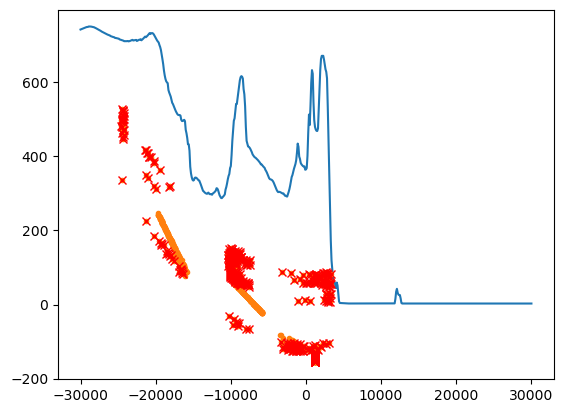

In [11]:
cryoswath.test_plots.waveform.dem_transect(l1b_data.isel(time_20_ku=200))

It seems the range window was not aligned well. There is nothing you can
do about it. Choose another example.